In [1]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import timm  # Make sure timm is installed: pip install timm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =======================
# 1. Data Preparation
# =======================
# CIFAR-10 dataset; note that we resize images to 224x224 because most pre-trained models (e.g. DINOv2) expect larger inputs.
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Using ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:02<00:00, 71.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# =======================
# 2. Model Setup
# =======================
feature_extractor = torch.hub.load('facebookresearch/dinov2', "dinov2_vitb14")
feature_extractor.to(device)  # move the model to CUDA
feature_extractor.eval()


# Freeze the backbone parameters
for param in feature_extractor.parameters():
    param.requires_grad = False

# Determine the feature dimension (e.g. 768 for ViT-B/14)
num_features = 768
num_classes = 10  # CIFAR-10 has 10 classes

# Create a linear classifier on top of the frozen features.
linear_classifier = nn.Linear(num_features, num_classes)
linear_classifier.to(device)


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:02<00:00, 132MB/s]


Linear(in_features=768, out_features=10, bias=True)

In [15]:
# =======================
# 3. Training Setup
# =======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(linear_classifier.parameters(), lr=0.01, momentum=0.9)
num_epochs = 4


In [16]:
# =======================
# 4. Training Loop (Linear Probe)
# =======================
from tqdm import tqdm

train_losses = []
train_accuracies = []

for epoch in tqdm(range(num_epochs), desc="Epochs progress"):
    linear_classifier.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for inputs, labels in tqdm(train_loader, desc=f"Training epoch {epoch+1}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Extract features using the frozen DINOv2 backbone.
        with torch.no_grad():
            features_dict = feature_extractor.forward_features(inputs)
            features = features_dict["x_norm_clstoken"]

        # Forward pass through the linear classifier.
        outputs = linear_classifier(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy stats
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute average loss & accuracy for this epoch
    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epochs progress:  25%|██▌       | 1/4 [02:53<08:40, 173.56s/it]

Epoch [1/4] - Loss: 0.0155, Accuracy: 99.55%



Epochs progress:  50%|█████     | 2/4 [05:47<05:47, 173.66s/it]

Epoch [2/4] - Loss: 0.0149, Accuracy: 99.58%



Epochs progress:  75%|███████▌  | 3/4 [08:41<02:53, 173.78s/it]

Epoch [3/4] - Loss: 0.0132, Accuracy: 99.66%



Epochs progress: 100%|██████████| 4/4 [11:35<00:00, 173.79s/it]

Epoch [4/4] - Loss: 0.0124, Accuracy: 99.65%


In [17]:
# =======================
# 5. Evaluation and Feature Extraction for Visualization
# =======================
linear_classifier.eval()
total = 0
correct = 0
all_features = []
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Test loader"):
        inputs, labels = inputs.to(device), labels.to(device)
        # Get dictionary of features and extract class token features.
        features_dict = feature_extractor.forward_features(inputs)
        features = features_dict["x_norm_clstoken"]

        # Ensure features is at least 2D (batch_size x feature_dim)
        if features.ndim < 2:
            features = features.unsqueeze(0)

        outputs = linear_classifier(features)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append the features (move to CPU)
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

        # Also store predictions for confusion matrix
        all_preds.append(predicted.cpu())

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.2f}%")

# Concatenate feature and label batches.
all_features_tensor = torch.cat(all_features, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)
all_preds_tensor = torch.cat(all_preds, dim=0)

# Convert to NumPy arrays.
all_features_np = all_features_tensor.numpy()
all_labels_np = all_labels_tensor.numpy()
all_preds_np = all_preds_tensor.numpy()


Test loader: 100%|██████████| 157/157 [00:34<00:00,  4.54it/s]

Test Accuracy: 97.80%


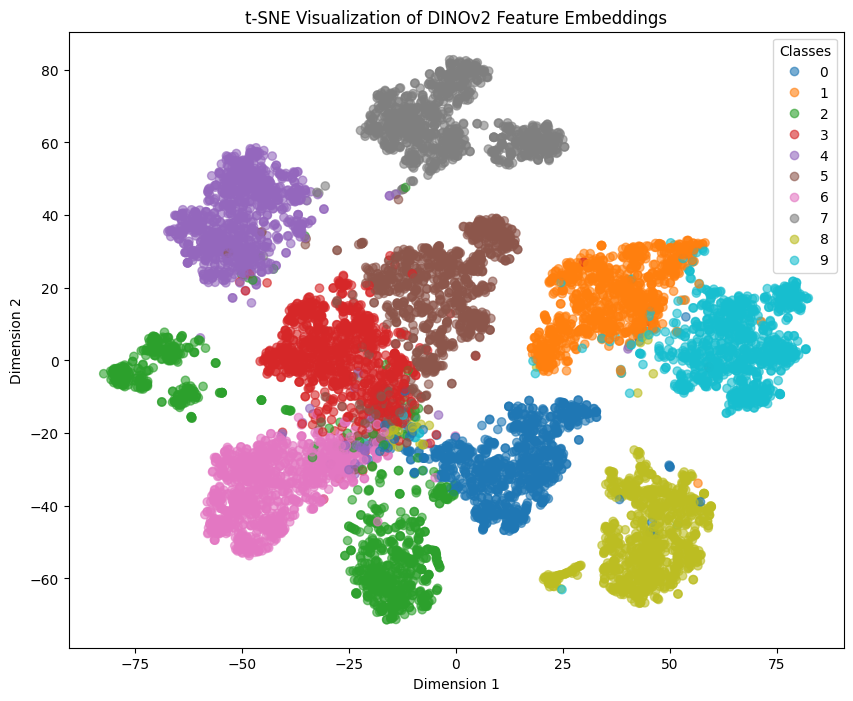

In [12]:
# Concatenate feature and label batches.
import numpy as np
all_features = np.concatenate([f if isinstance(f, np.ndarray) else f.numpy() for f in all_features], axis=0)
all_labels = np.concatenate([l if isinstance(l, np.ndarray) else l.numpy() for l in all_labels], axis=0)


# =======================
# 6. Dimensionality Reduction and Visualization (t-SNE)
# =======================
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization of DINOv2 Feature Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

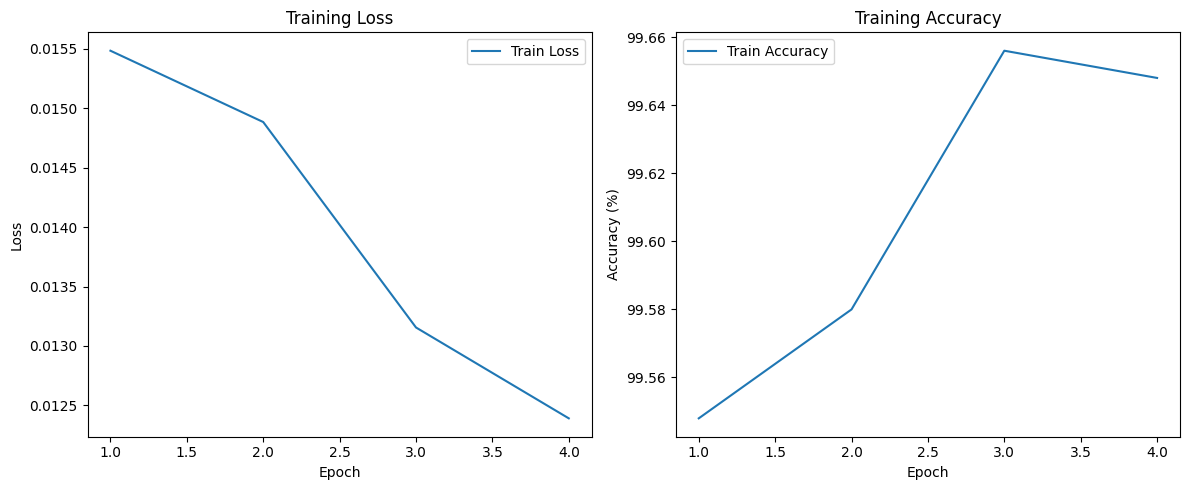

In [20]:
import matplotlib.pyplot as plt

epochs_list = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


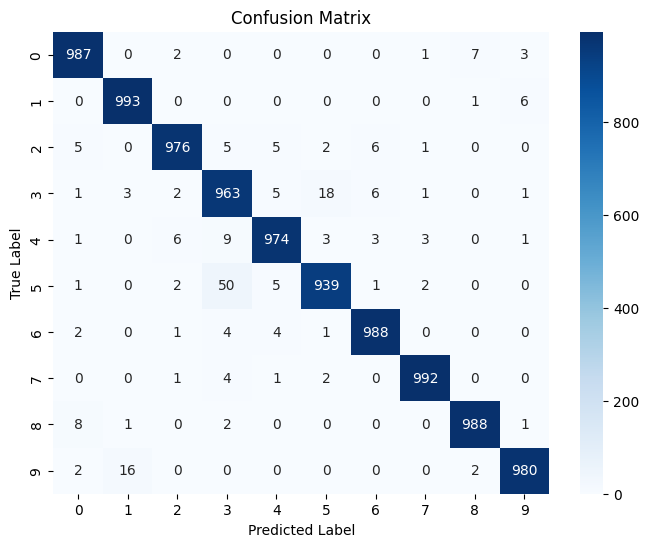

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(all_labels_np, all_preds_np)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
